# Regularization effect on autoencoder

In [1]:
import time
from typing import Tuple, Dict, Union, List

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics

In [2]:
NUMBER_PARAM = 10
REGULARIZER_TYPE = 'activity_regularizer'
LS_KERNEL_REGULARIZER = np.zeros(NUMBER_PARAM)
LS_ACTIVITY_REGULARIZER = np.linspace(0, 1e-4, NUMBER_PARAM)

## 1. Data prep

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
x_train_norm = x_train/np.max(x_train)
x_test_norm = x_test/np.max(x_test)

## 2. Model architecture

The following model is to minimize loss function, $L_T$, in terms of loss from regular autoencoder, $L$, plus regularization term, $R$.

**Encoding layer:**  
$h = \alpha_e(W_1 \times\ x + b_1)$, where $\alpha_e(.)$ is activation function *ReLU*, 
and the number of hidden units in $h$ is 196. Hence $h$ is a 196x1 vector in **196-dim latent space**, $W_1$ is 196x748 weight matrix and $b_1$ is the bias term in the form of 196x1 vector.  
**Decoding layer:**  
$x' = \alpha_d(W_2 \times\ h + b_2)$, where $\alpha_d(.)$ is activation function *sigmoid*, $x'$ is the output of the autoencoder
which is optimized to reconstruct back to input $x$.  
**Loss function:**  
$L_T = L + R = ||x - x'||^2 + \lambda_a\sum |h_i| + \lambda_k\sum |W_1|$, where $i$ is the number of hidden units, $\lambda_k\ \lambda_a\$ are kernel and activity regularizer respectively, *l1* regularization is used.

In [5]:
class Autoencoder(tf.keras.Model):
    def __init__(
        self, 
        input_shape: Tuple[int,int], 
        encoding_dim: int,
        activity_regularizer: float,
        kernel_regularizer: float,
        **kwargs
    ) -> None:
        
        super().__init__(**kwargs)
        self.encoding_dim = encoding_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(
                encoding_dim, 
                activation='relu', 
                activity_regularizer=tf.keras.regularizers.L1(activity_regularizer),
                kernel_regularizer=tf.keras.regularizers.L1(kernel_regularizer)
            )
        ])
        self.decoder = tf.keras.Sequential([
          tf.keras.layers.Dense(
              input_shape[0]*input_shape[1], 
              activation='sigmoid'
          ),
          tf.keras.layers.Reshape(input_shape)
        ])
        
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

## 3. Training

In [6]:
def training(
    train_set: np.ndarray,
    test_set: np.ndarray,
    activity_regularizer: float,
    kernel_regularizer: float,
    encoding_dim: int,
) -> Dict[str, Union[Autoencoder, float, int, np.ndarray]]:
    
    # build
    autoencoder = Autoencoder(
        input_shape=(28, 28),
        encoding_dim=encoding_dim,
        activity_regularizer=activity_regularizer,
        kernel_regularizer=kernel_regularizer,
    )
    autoencoder.compile(optimizer='adam', loss='mse')
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

    # fit
    print(f'Training start:')
    print(f'activity_regularizer = {activity_regularizer}')
    print(f'kernel_regularizer = {kernel_regularizer}')
    start = time.time()
    history = autoencoder.fit(
        train_set, train_set,
        callbacks=[callback],
        epochs=100,
        batch_size=256,
        shuffle=True,
        verbose=0,
        validation_data=(test_set, test_set)
    )
    end = time.time()

    # eval
    training_loss = history.history.get('loss')[-1]
    testing_loss = history.history.get('val_loss')[-1]
    epoch = max(history.epoch)
    print('Training results:')
    print(f'training_loss = {training_loss}')
    print(f'testing_loss = {testing_loss}')
    print(f'epoch = {epoch}')
    print(f'time passed = {int(round(end-start))}s')
    print('-'*100)
    
    # return
    w1, _, _, _ = autoencoder.get_weights()
    w1_reshape = w1.T.reshape((encoding_dim,28,28))
    result = {
        'hyperparam': {
            'activity_regularizer': activity_regularizer,
            'kernel_regularizer': kernel_regularizer,
        },
        'results': {
            'training_loss': training_loss, 
            'testing_loss': testing_loss, 
            'epoch': epoch,
            'model': autoencoder,
            'w1_reshape': w1_reshape,
        }
    }
    
    return result

In [7]:
training_results = list()
for kernel_regularizer, activity_regularizer in zip(LS_KERNEL_REGULARIZER,LS_ACTIVITY_REGULARIZER):
    result = training(
        train_set=x_train_norm, 
        test_set=x_test_norm,
        activity_regularizer=activity_regularizer,
        kernel_regularizer=kernel_regularizer,
        encoding_dim=196
    )
    training_results.append(result)

Training start:
activity_regularizer = 0.0
kernel_regularizer = 0.0
Training results:
training_loss = 0.0014384868554770947
testing_loss = 0.0014469390735030174
epoch = 23
time passed = 25s
----------------------------------------------------------------------------------------------------
Training start:
activity_regularizer = 5e-05
kernel_regularizer = 0.0
Training results:
training_loss = 0.0035653698723763227
testing_loss = 0.0036459765397012234
epoch = 49
time passed = 52s
----------------------------------------------------------------------------------------------------
Training start:
activity_regularizer = 0.0001
kernel_regularizer = 0.0
Training results:
training_loss = 0.00442089606076479
testing_loss = 0.004511271603405476
epoch = 60
time passed = 63s
----------------------------------------------------------------------------------------------------


## 4. Loss plot

MSE loss ($L_T$) against hyperparameter, `activity_regularizer` ($\lambda$), for training set and testing set

In [8]:
def loss_plot(results) -> None:
    param = list()
    training_loss = list()
    testing_loss = list()
    for result in results:
        param.append(result['hyperparam'][REGULARIZER_TYPE])
        training_loss.append(result['results']['training_loss'])
        testing_loss.append(result['results']['testing_loss'])

    plt.figure(figsize=(12, 8))
    plt.plot(param, testing_loss, 'bs', label='testing_loss')
    plt.plot(param, training_loss, 'r^', label='training_loss')
    plt.ylabel('loss')
    plt.xlabel(REGULARIZER_TYPE)
    plt.title('Training loss vs testing loss')
    plt.legend(loc='upper left')
    plt.show()
    plt.close()

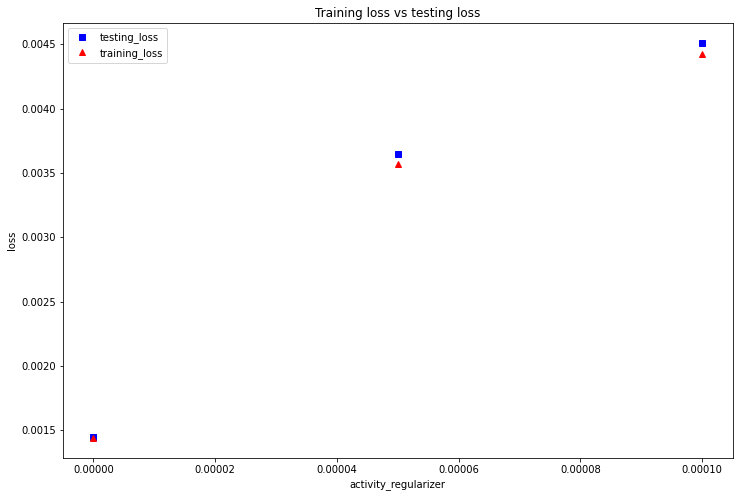

In [9]:
loss_plot(results=training_results)

## 5. Sparsity plot

Sparsity of $h$ against hyperparameter, `activity_regularizer` ($\lambda$), for training set and testing set 

In [10]:
def _sparsity_map(x: int) -> None:
    if x != 0:
        return 1
    else:
        return 0
    
_sparsity_map_vec = np.vectorize(_sparsity_map)

def plot_sparsity(
    results, 
    train_set, 
    test_set
) -> None:
    param = list()
    ls_training_sparsity = list()
    ls_testing_sparsity = list()
    for result in results:
        param.append(result['hyperparam'][REGULARIZER_TYPE])
        model = result['results']['model']
        train_encoded_imgs = model.encoder(train_set).numpy()
        test_encoded_imgs = model.encoder(test_set).numpy()
        train_sparsity = np.sum(_sparsity_map_vec(train_encoded_imgs))/train_encoded_imgs.size
        testing_sparsity = np.sum(_sparsity_map_vec(test_encoded_imgs))/test_encoded_imgs.size
        ls_training_sparsity.append(train_sparsity)
        ls_testing_sparsity.append(testing_sparsity)
        
    plt.figure(figsize=(12, 8))
    plt.plot(param, ls_testing_sparsity, 'bs', label='testing_sparsity')
    plt.plot(param, ls_training_sparsity, 'r^', label='training_sparsity')
    plt.ylabel('sparsity')
    plt.xlabel(REGULARIZER_TYPE)
    plt.title('Training sparsity vs testing sparsity')
    plt.legend(loc='upper right')
    plt.show()
    plt.close()

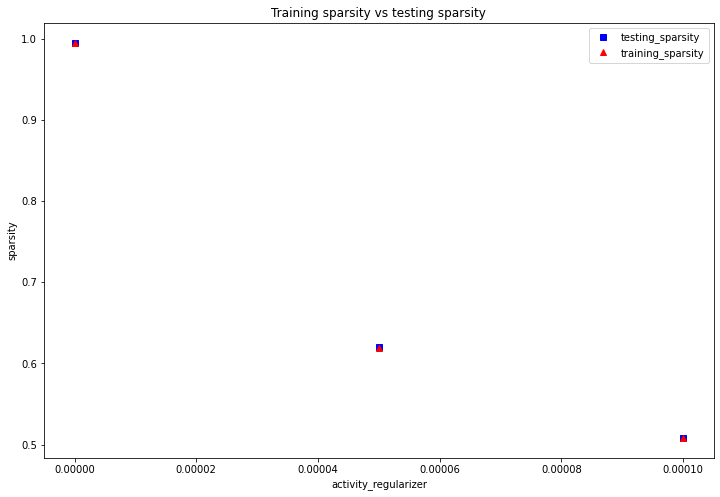

In [11]:
plot_sparsity(
    results=training_results,
    train_set=x_train_norm,
    test_set=x_test_norm,
)

## 6. Weight matrix of the encoder

Weight matrix of the encoder, $W_1$, is shown on a grey-scale heatmap. Each of the subplot showing a row frm $W_1$ reshaped to 28x28

In [12]:
def plot_w1(
    w1: np.ndarray
) -> None:
    
    w1_dim = int(np.sqrt(len(w1)))
    fig, ax = plt.subplots(
        nrows=w1_dim, 
        ncols=w1_dim, 
        figsize=(w1_dim,w1_dim)
    )
    plt.gray()

    i = 0
    for row in ax:
        for col in row:
            col.imshow(w1[i])
            col.get_xaxis().set_visible(False)
            col.get_yaxis().set_visible(False)
            i = i + 1
            
    plt.show()
    plt.close()

{'activity_regularizer': 0.0, 'kernel_regularizer': 0.0}


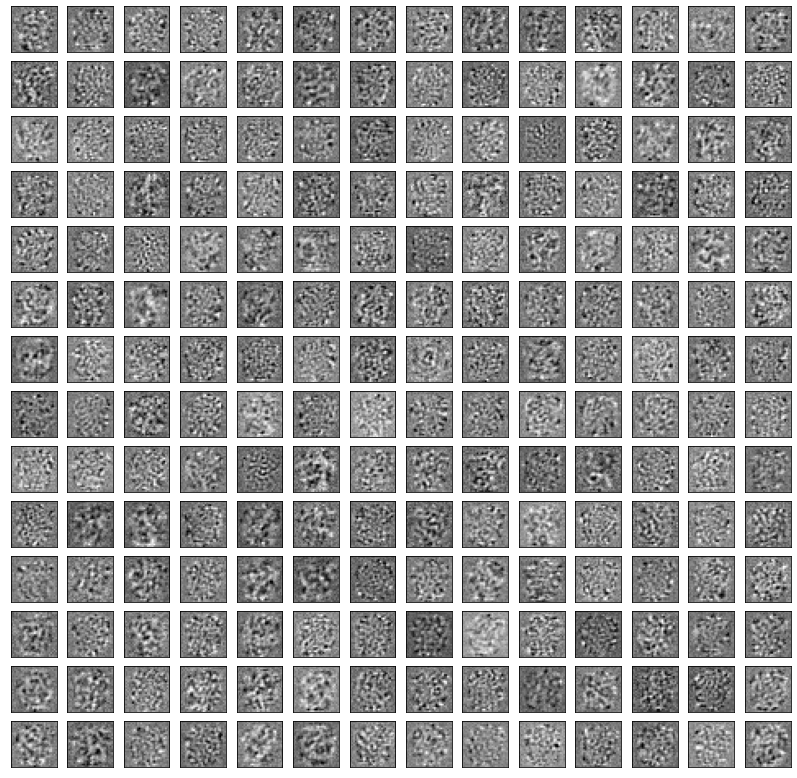

{'activity_regularizer': 5e-05, 'kernel_regularizer': 0.0}


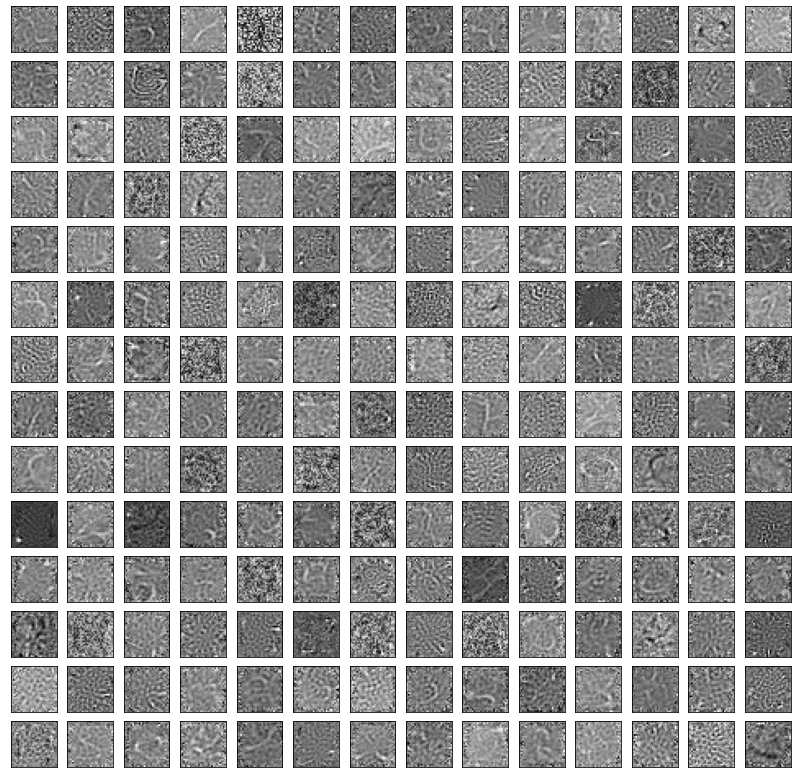

{'activity_regularizer': 0.0001, 'kernel_regularizer': 0.0}


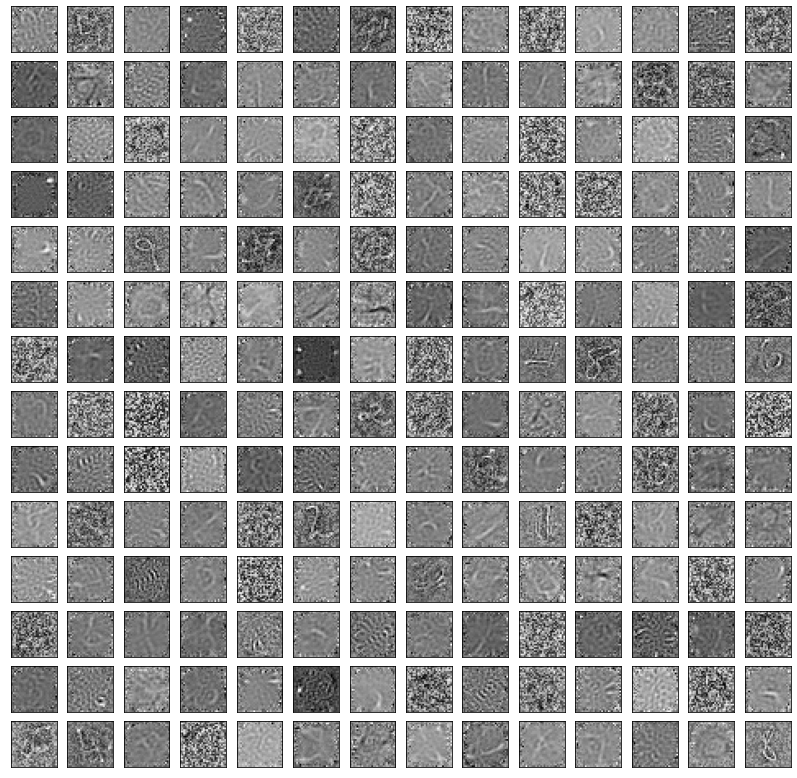

In [13]:
for result in training_results:
    hyperparam = result['hyperparam']
    print(hyperparam)
    plot_w1(
        w1=result['results']['w1_reshape']
    )

## 7. Original image vs latent space vs reconstructed image

In [14]:
def plot_images(
    img_gp: List[np.ndarray],
    num_img: int,
) -> None:
    
    _, ax = plt.subplots(nrows=len(img_gp), ncols=num_img, figsize=(num_img,len(img_gp)))
    plt.gray()
    for i, row in enumerate(ax):
        tmp = img_gp[i]
        for j, col in enumerate(row):
            col.imshow(tmp[j])
            col.get_xaxis().set_visible(False)
            col.get_yaxis().set_visible(False)
            
    plt.show()
    plt.close()

{'activity_regularizer': 0.0, 'kernel_regularizer': 0.0}


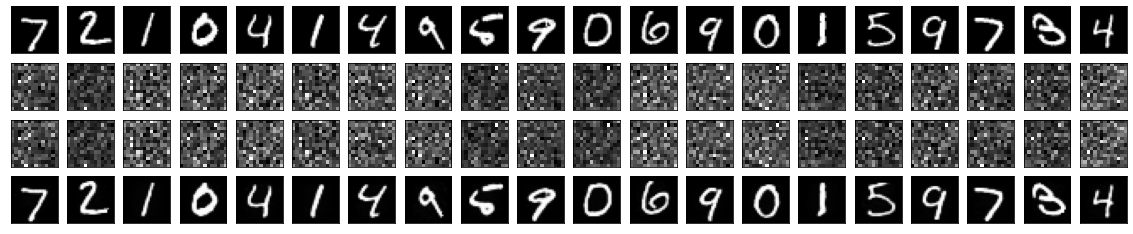

{'activity_regularizer': 5e-05, 'kernel_regularizer': 0.0}


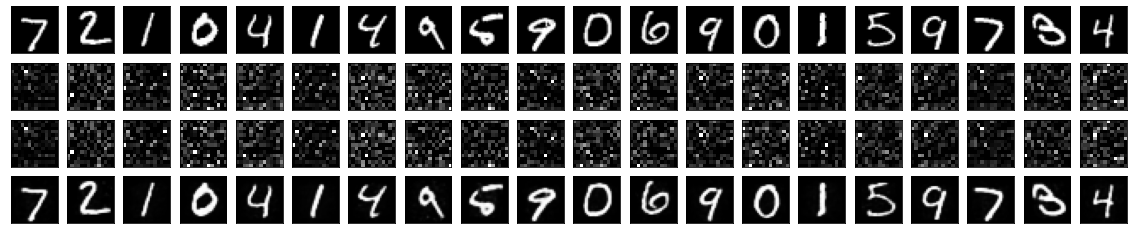

{'activity_regularizer': 0.0001, 'kernel_regularizer': 0.0}


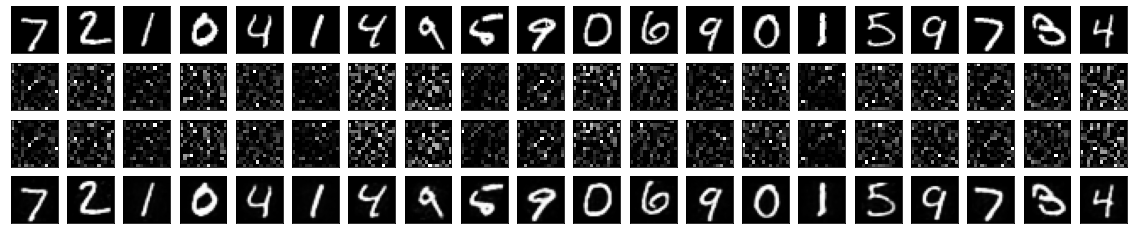

In [15]:
num_img = 20
img = x_test_norm[:num_img]
for result in training_results:
    hyperparam = result['hyperparam']
    print(hyperparam)
    
    model = result['results']['model']
    encoded_img = model.encoder(img).numpy()
    norm_encoded_img = np.divide(encoded_img,np.linalg.norm(encoded_img, axis=1).reshape(-1,1))
    decoded_img = model.decoder(encoded_img).numpy()
    latent_dim = int(np.sqrt(len(encoded_img.T)))
    encoded_img_reshape = encoded_img.reshape((num_img,latent_dim,latent_dim))
    norm_encoded_img_reshape = norm_encoded_img.reshape((num_img,latent_dim,latent_dim))
    
    img_gp = [img, encoded_img_reshape, norm_encoded_img_reshape, decoded_img]
    plot_images(
        img_gp=img_gp,
        num_img=num_img,
    )

## 8. Latent space similarity plot

In [16]:
def similarity_plot(
    img: np.ndarray, 
    ls_label: List[int]
) -> None:
    
    similarity_matrix = img @ img.T
    ls_similarity = [list() for i in range(10)]
    ls_disimilarity = [list() for i in range(10)]
    for i, u in enumerate(similarity_matrix):
        for j, v in enumerate(u):
            if i == j:
                continue
            if ls_label[i] == ls_label[j]:
                label = ls_label[i]
                ls_similarity[label].append(v)
            else:
                label = ls_label[i]
                ls_disimilarity[label].append(v)
    
    plot_data = [
        {
            'data': ls_similarity,
            'title': 'Cosine similarity of the latent vector with the same label'
        },
        {
            'data': ls_disimilarity,
            'title': 'Cosine similarity of the latent vector with the different label',
        }
    ]
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(24,8))
    for idx, col in enumerate(ax):
        col.boxplot(plot_data[idx]['data'])
        col.set_title(plot_data[idx]['title'])
        col.set_ylim([0,1])
        col.set_xticks(range(1,11))
        col.set_xticklabels(range(10))
        col.set_xlabel('label')
        col.set_ylabel('cosine similarity')
        
    plt.show()
    plt.close()

{'activity_regularizer': 0.0, 'kernel_regularizer': 0.0}


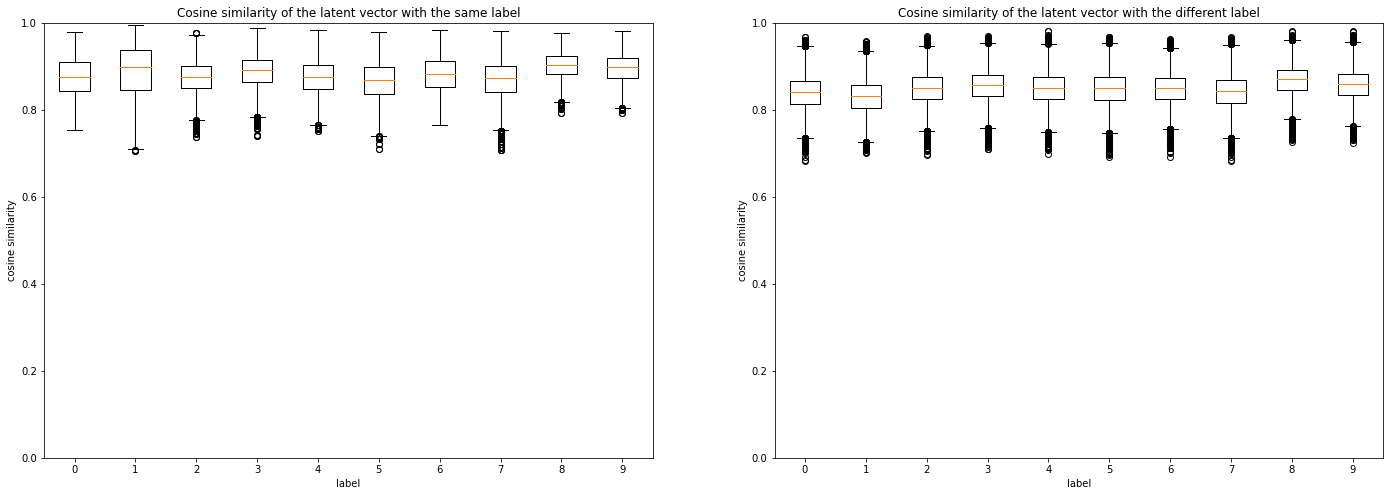

{'activity_regularizer': 5e-05, 'kernel_regularizer': 0.0}


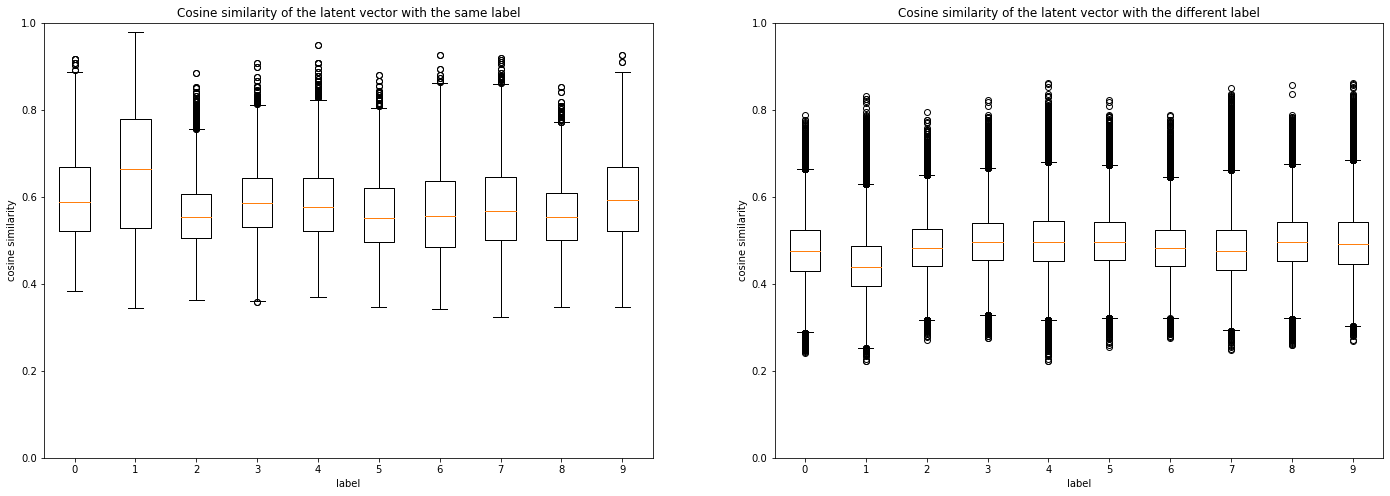

{'activity_regularizer': 0.0001, 'kernel_regularizer': 0.0}


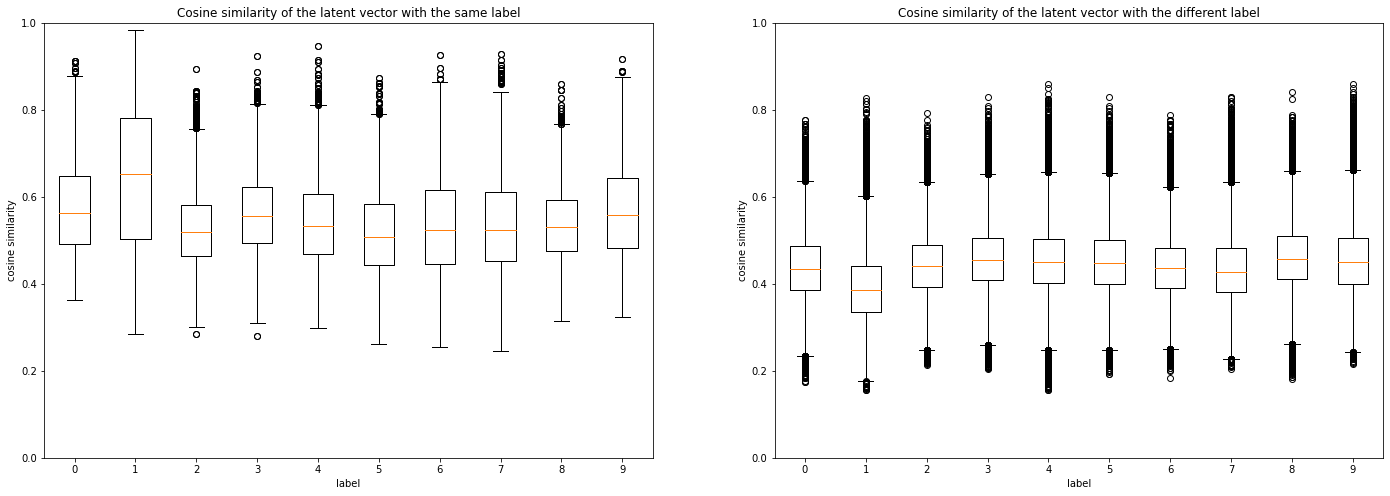

In [17]:
num_img = 1000
img = x_test_norm[:num_img]
img_label = y_test[:num_img]
for result in training_results:
    hyperparam = result['hyperparam']
    print(hyperparam)
    model = result['results']['model']
    encoded_img = model.encoder(img).numpy()
    norm_encoded_img = np.divide(encoded_img,np.linalg.norm(encoded_img, axis=1).reshape(-1,1))
    similarity_plot(img=norm_encoded_img, ls_label=img_label)

## 9. Latent space in T-SNE space

In [18]:
def tsne_plot(
    space_gp: List[np.ndarray],
    label: List[int]
) -> None:
    
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    for idx, col in enumerate(ax):
        space = space_gp[idx]['space']
        scatter = col.scatter(space[:,0], space[:,1], c=label, cmap='Spectral')
        col.set_title(space_gp[idx]['title'])
        col.set_xlabel('tsne 1')
        col.set_ylabel('tsne 2')
        col.legend(*scatter.legend_elements())
    plt.show()
    plt.close()

{'activity_regularizer': 0.0, 'kernel_regularizer': 0.0}
fitting tsne for encoded_img
fitting tsne for norm_encoded_img


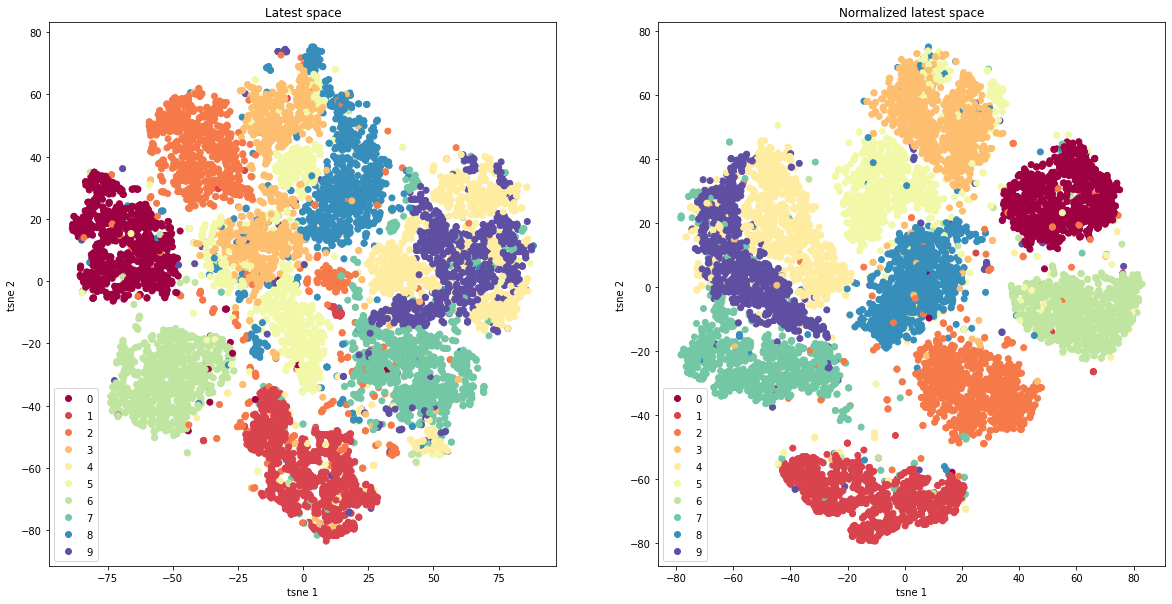

{'activity_regularizer': 5e-05, 'kernel_regularizer': 0.0}
fitting tsne for encoded_img
fitting tsne for norm_encoded_img


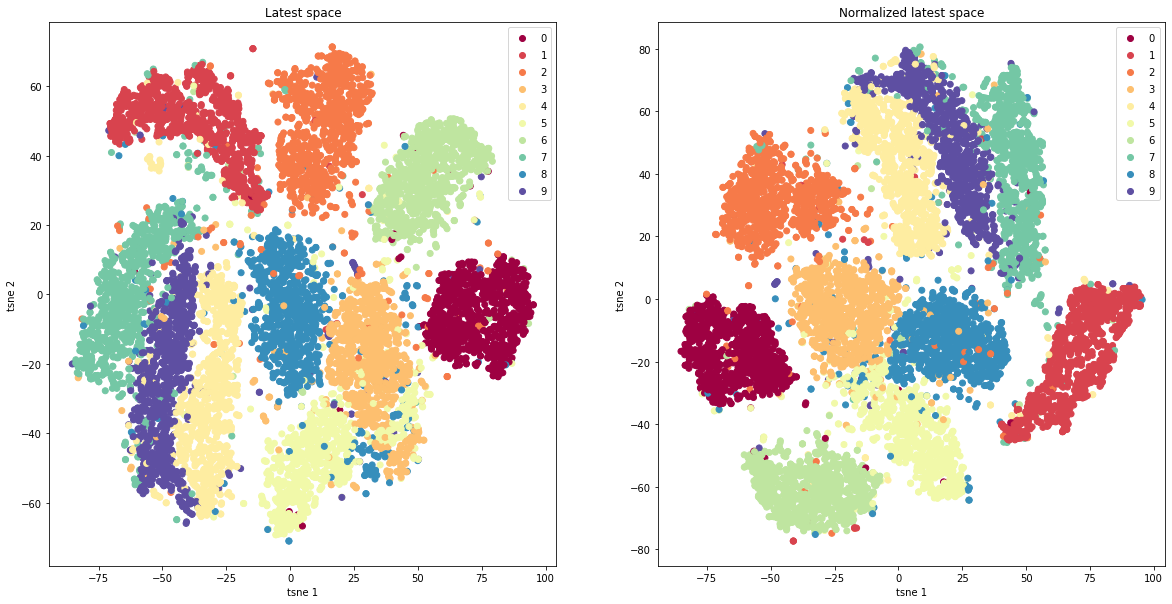

{'activity_regularizer': 0.0001, 'kernel_regularizer': 0.0}
fitting tsne for encoded_img
fitting tsne for norm_encoded_img


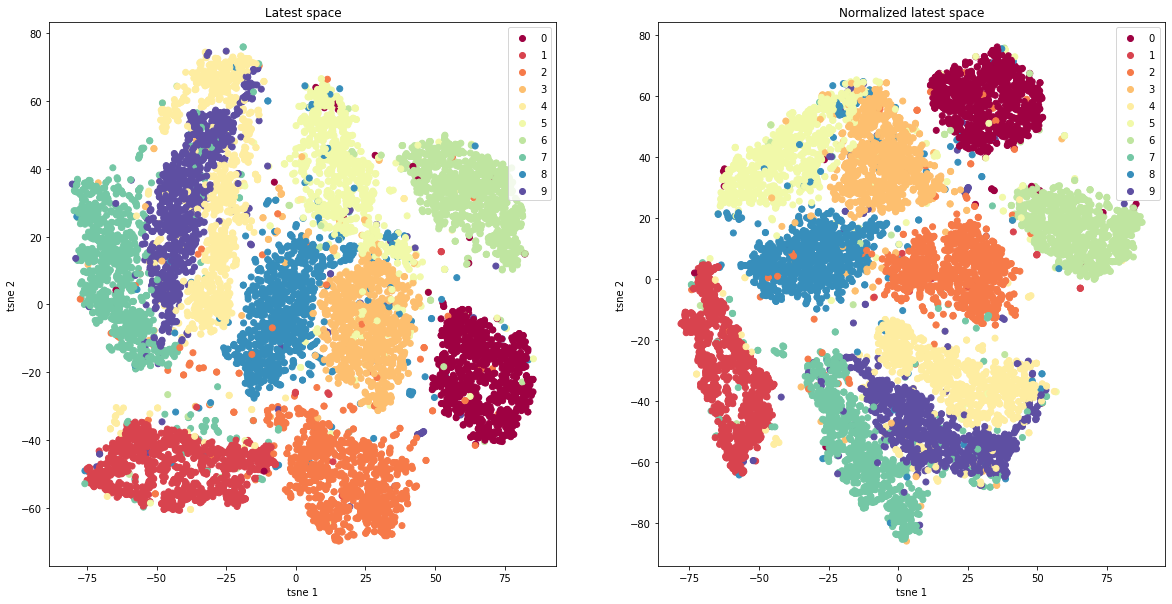

In [19]:
for result in training_results:
    model = result['results']['model']
    hyperparam = result['hyperparam']
    print(hyperparam)
    encoded_img = model.encoder(x_test_norm).numpy()
    norm_encoded_img = np.divide(encoded_img,np.linalg.norm(encoded_img, axis=1).reshape(-1,1))
    print('fitting tsne for encoded_img')
    tsne_space = TSNE(n_components=2, n_jobs=-1).fit_transform(encoded_img)
    print('fitting tsne for norm_encoded_img')
    tsne_space_norm = TSNE(n_components=2, n_jobs=-1).fit_transform(norm_encoded_img)
    space_gp = [
        {
            'space': tsne_space,
            'title': 'Latest space',
        },
        {
            'space': tsne_space_norm,
            'title': 'Normalized latest space',
        },
    ]
    tsne_plot(space_gp=space_gp, label=y_test)

## 10. K-Mean plot

In [20]:
def kmean_plot(
    space_gp: List[np.ndarray],
    max_n_cluster: int = 10,
) -> None:
    
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    for idx, col in enumerate(ax):
        ls_silhouette_score = list()
        range_clusters = range(2,max_n_cluster+1)
        for n_clusters in range(2,max_n_cluster+1):
            x = space_gp[idx]['space']
            kmeans = KMeans(n_clusters=n_clusters)
            kmeans.fit(x)
            labels = kmeans.labels_
            silhouette_score = metrics.silhouette_score(x, labels, metric='euclidean')
            ls_silhouette_score.append(silhouette_score)
        col.plot(range_clusters, ls_silhouette_score, 'bs')
        col.set_title(space_gp[idx]['title'])
        col.set_xlabel('number of clusters')
        col.set_ylabel('silhouette score')
    plt.show()
    plt.close()

{'activity_regularizer': 0.0, 'kernel_regularizer': 0.0}


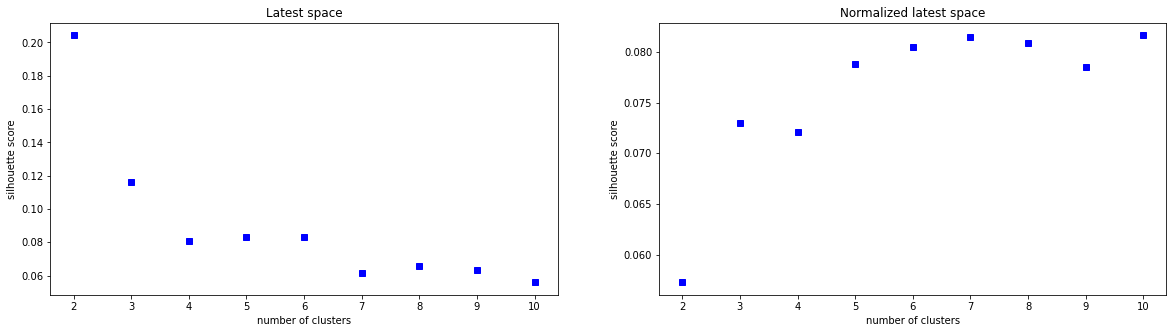

{'activity_regularizer': 5e-05, 'kernel_regularizer': 0.0}


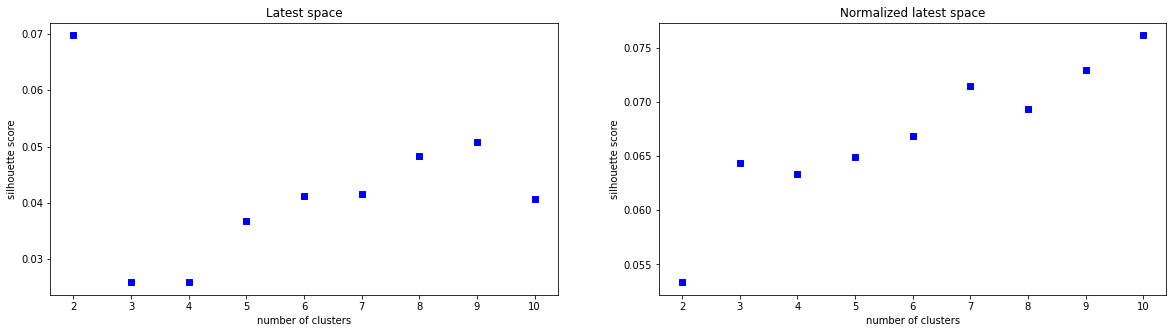

{'activity_regularizer': 0.0001, 'kernel_regularizer': 0.0}


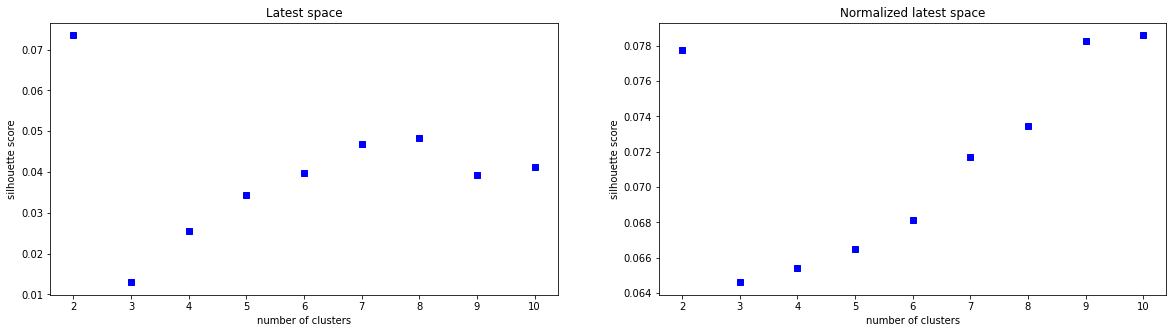

In [21]:
ls_inertia = list()
for result in training_results:
    model = result['results']['model']
    hyperparam = result['hyperparam']
    print(hyperparam)
    encoded_img = model.encoder(x_test_norm).numpy()
    norm_encoded_img = np.divide(encoded_img,np.linalg.norm(encoded_img, axis=1).reshape(-1,1))
    space_gp = [
        {
            'space': encoded_img,
            'title': 'Latest space',
        },
        {
            'space': norm_encoded_img,
            'title': 'Normalized latest space',
        },
    ]
    kmean_plot(space_gp=space_gp)